# 03 - SVM

## Prerequisites

- The dataset exists (if not, execute 00 - Dataset Initialisation)
- The dataset features have been populated (if not, execute 02 - Features Computation)


In [4]:
import warnings                              # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')            # commented out till the experiment final version,
                                             # in order to avoid missing "real" warnings 
from IPython.display import display
import kilroy_was_here                       # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import iprint
from audace.audiodataset import AudioDataset # Main class for audio dataset handling

# Experiment name will be used to prefix potential outputs
EXP_NAME = "03 - SVM"

# Dataset name is the master key for dataset adressing
# Change it according to the dataset you want to process
DATASET_NAME = 'MAIN1000'

# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

# Display cardinalities by hive attribute and queen label for samples with no external perturbation
sql = """
    select distinct hive, queen, count(*)
    from samples
    where nobee = 0
    group by hive, queen
    order by hive
    """
display(ds.queryDataFrame(sql))

[2020-08-23/14:34:57.730|09.8%|79.7%|0.26GB] ------------------------------------------------------
[2020-08-23/14:34:57.730|00.0%|79.7%|0.26GB] DATASET NAME          : MAIN1000
[2020-08-23/14:34:57.731|00.0%|79.7%|0.26GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN1000
[2020-08-23/14:34:57.731|00.0%|79.7%|0.26GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN1000\MAIN1000.db
[2020-08-23/14:34:57.731|00.0%|79.7%|0.26GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN1000\samples
[2020-08-23/14:34:57.732|00.0%|79.7%|0.26GB] NB SOURCE AUDIO FILES : 48
[2020-08-23/14:34:57.732|00.0%|79.7%|0.26GB] SAMPLE RATE           : 22050
[2020-08-23/14:34:57.732|00.0%|79.7%|0.26GB] DURATION              : 1.0
[2020-08-23/14:34:57.732|00.0%|79.7%|0.26GB] OVERLAP               : 0.0
[2020-08-23/14:34:57.733|00.0%|79.7%|0.26GB] NB AUDIO CHUNKS       : 24788
[2020-08-23/14:34:57.734|00.0%|79.7%|0.26GB] ------------------------------------------------------


,hive,queen,count(*)
0,CF001,0.0,14
1,CF003,1.0,3649
2,CJ001,0.0,790
3,GH001,1.0,1396
4,Hive1,0.0,1473
5,Hive1,1.0,2684
6,Hive3,0.0,6545
7,Hive3,1.0,654


In [41]:
import numpy as np
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from audace.jupytools import predestination
from audace.audiodataset import feature_serie_to_np

# Experiment parameters
FEATURE_NAME = 'apidictor'
SET_FRAC = 1
TEST_FRAC = 0.99
KERNEL = 'rbf'
C = 1
GAMMA = 'scale'

# Seed the various PRNGs
#predestination()

# Get pandas dataframe containing the columns we will need for this experiments,
# shuffle it (and potentially truncate it to speed quick tests)
sql = F"select {FEATURE_NAME}, queen from samples where nobee = 0"
df = ds.queryDataFrame(sql).sample(frac=SET_FRAC)

# flatten features array
X = feature_serie_to_np(df[FEATURE_NAME])

# get labels
y = df['queen']

# Partition dataset into training and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRAC)

# It is usually a good idea to scale the data for SVM training. Classifiers usually
#perform better on normalized data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Create a svm Classifier, using the experiment parameters
clf = svm.SVC(kernel=KERNEL, C=C, gamma=GAMMA)

iprint('>>>>> Train')
#Train the model using the training sets
clf.fit(X_train, y_train)

iprint('>>>>> Predict')
#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Display information about the classifier performance
iprint(F"Trained over {len(y_train)} / Tested over {len(y_test)}")
iprint("Accuracy  :",metrics.accuracy_score(y_test, y_pred))
iprint("Precision :",metrics.precision_score(y_test, y_pred))
iprint("Recall    :",metrics.recall_score(y_test, y_pred))
iprint("F-Measure :",metrics.f1_score(y_test, y_pred))


[2020-08-23/15:21:45.457|07.4%|74.2%|0.24GB] >>>>> Train
[2020-08-23/15:21:45.459|33.3%|74.2%|0.24GB] >>>>> Predict
[2020-08-23/15:21:45.536|11.1%|74.2%|0.24GB] Trained over 172 / Tested over 17033
[2020-08-23/15:21:45.538|28.6%|74.2%|0.24GB] Accuracy  : 0.643398109552046
[2020-08-23/15:21:45.545|00.0%|74.2%|0.24GB] Precision : 0.5962770562770563
[2020-08-23/15:21:45.552|00.0%|74.2%|0.24GB] Recall    : 0.8299590262713907
[2020-08-23/15:21:45.558|20.0%|74.2%|0.24GB] F-Measure : 0.6939742039500202


In [42]:
for hive in ds.listAttributeValues('hive'):
    hive_df = ds.queryDataFrame(F"select {FEATURE_NAME}, queen from samples where nobee = 0 and hive = '{hive}'")
    hive_X = scaler.transform(feature_serie_to_np(hive_df[FEATURE_NAME]))
    hive_y = hive_df['queen']
    hive_y_pred = clf.predict(hive_X)
    print(hive, metrics.accuracy_score(hive_y, hive_y_pred))
    



CF001 0.8571428571428571
GH001 0.3531518624641834
CF003 1.0
CJ001 0.0
Hive1 0.5275439018522974
Hive3 0.658285873037922


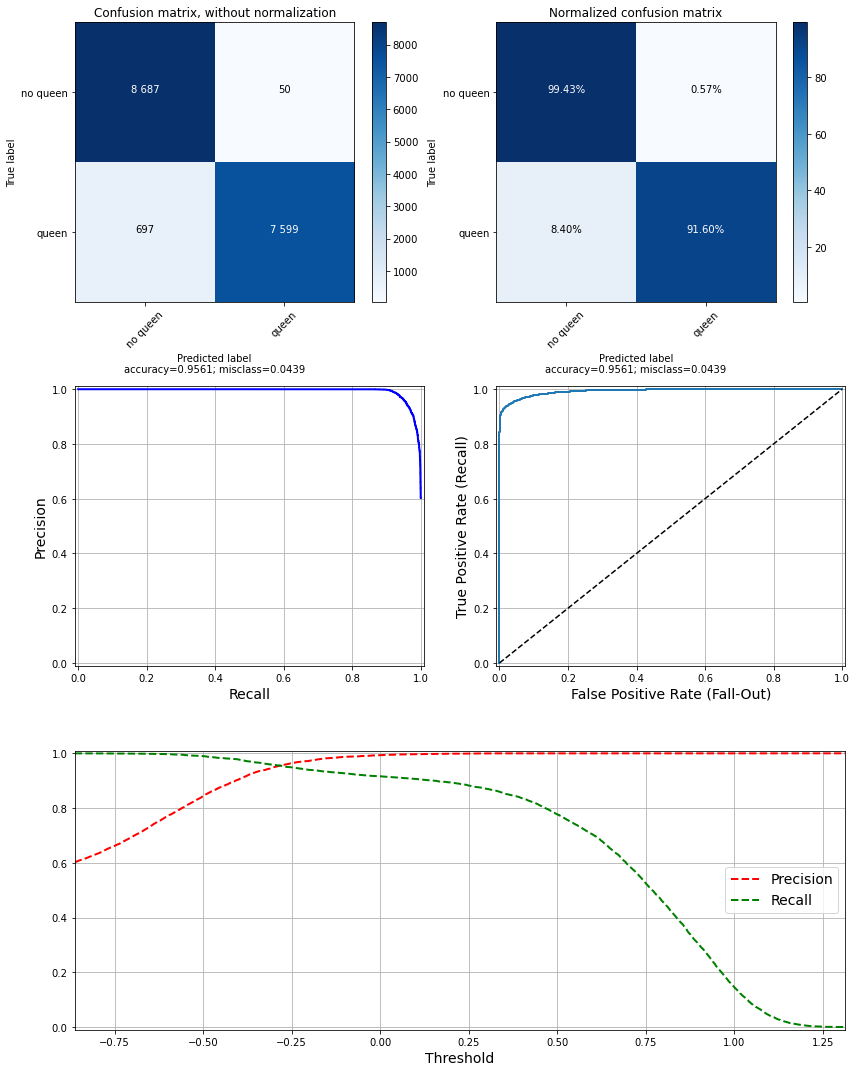

------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    no queen       0.93      0.99      0.96      8737
       queen       0.99      0.92      0.95      8296

    accuracy                           0.96     17033
   macro avg       0.96      0.96      0.96     17033
weighted avg       0.96      0.96      0.96     17033

------------------------------------------------------------------------------------------
Area Under ROC Curve 0.9930659067628124
------------------------------------------------------------------------------------------


In [31]:
from audace.plotters import clf_full_report
from sklearn import metrics

target_names = ['no queen', 'queen']

tst = int(100*TEST_FRAC)
trn = 100 -tst

figure_name = EXP_NAME + F"{KERNEL} - ({DATASET_NAME}) - [Trn{trn:02d},Tst{tst:02d}] - C{C}"
if KERNEL != 'linear':
    figure_name += F" - G{GAMMA}"

clf_full_report(clf, X_test, y_test, target_names, figure_name)


print("------------------------------------------------------------------------------------------")
print(metrics.classification_report(y_test, y_pred , target_names=target_names))
print("------------------------------------------------------------------------------------------")
print('Area Under ROC Curve', metrics.roc_auc_score(y_test, clf.decision_function(X_test)))
print("------------------------------------------------------------------------------------------")

-------------------------------------
Accuracy: 0.34348480700793865
Precision: 0.00012112403100775194
Recall: 0.0007468259895444362
F1: 0.00020844189682126107


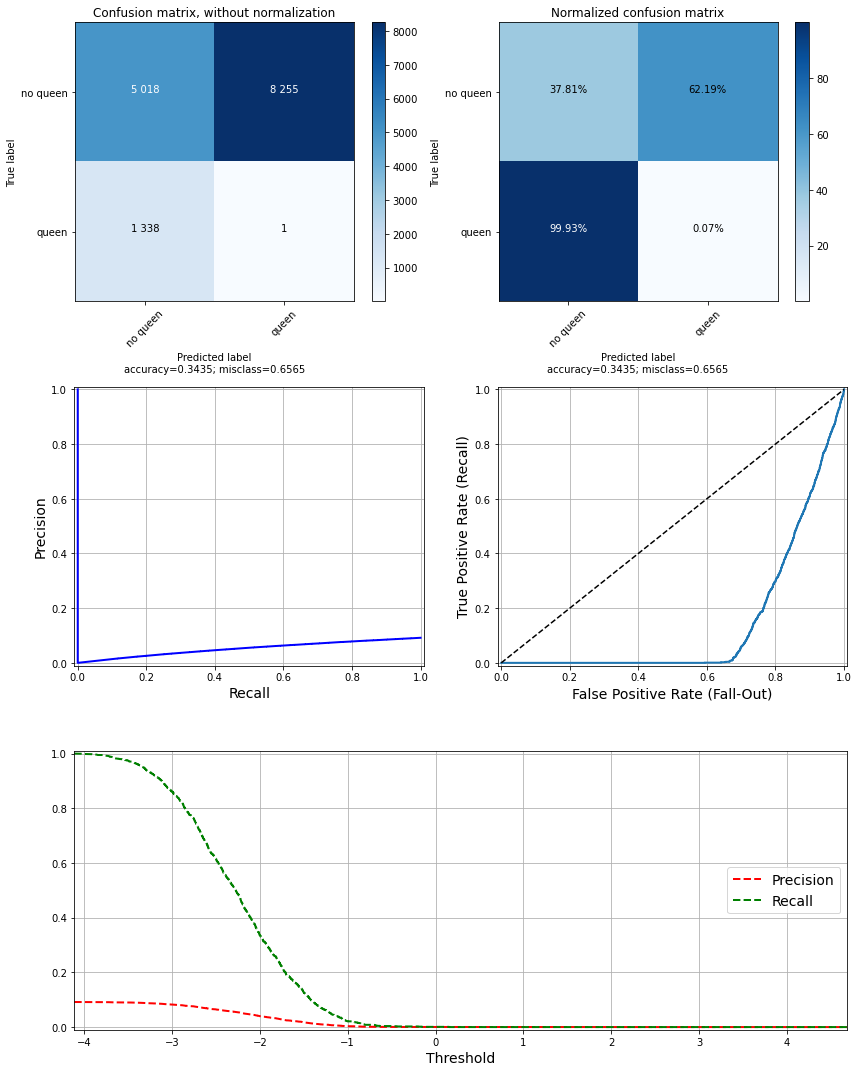

-------------------------------------
Accuracy: 0.3182401680476135
Precision: 0.0514018691588785
Recall: 0.004030780505679736
F1: 0.0074753652735304104


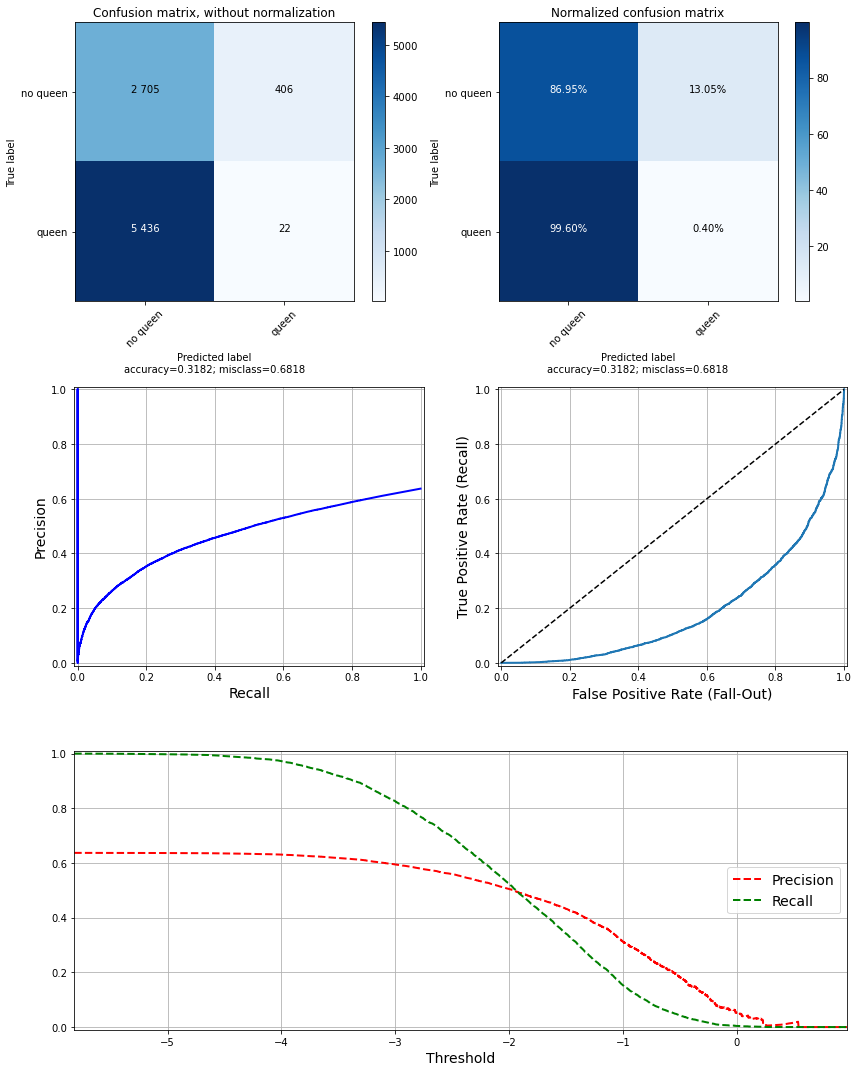

In [9]:
from sklearn import svm
from sklearn import metrics
from audace.plotters import clf_full_report
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer

FEATURE_NAME = 'mfcc8'
KERNEL = 'rbf'
C = 1
GAMMA = 'scale'
target_names = ['no queen', 'queen']

df_fold1 = ds.queryDataFrame(F"select {FEATURE_NAME}, queen from samples where nobee = 0 and hive = 'Hive1'").sample(frac=1)
df_fold2 = ds.queryDataFrame(F"select {FEATURE_NAME}, queen from samples where nobee = 0 and hive = 'Hive3'").sample(frac=1)




def process_svm(X_train_serie, y_train, X_test_serie, y_test):
    X_train = feature_serie_to_np(X_train_serie)
    X_test = feature_serie_to_np(X_test_serie)

    #Create a svm Classifier
    clf = svm.SVC(kernel=KERNEL, C=C, gamma=GAMMA)

    scaler = StandardScaler()    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    
    
    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("-------------------------------------")
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred))
    print("Recall:",metrics.recall_score(y_test, y_pred))
    print("F1:",metrics.f1_score(y_test, y_pred))
    
    return clf, X_test, y_test


c, X, y = process_svm(df_fold1[FEATURE_NAME], df_fold1['queen'], df_fold2[FEATURE_NAME], df_fold2['queen'])
clf_full_report(c, X, y, target_names)

c, X, y = process_svm(df_fold2[FEATURE_NAME], df_fold2['queen'], df_fold1[FEATURE_NAME], df_fold1['queen'])
clf_full_report(c, X, y, target_names)

